In [1]:
from math import cos, exp, pi, tanh, sqrt
from scipy.integrate import quad, dblquad
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from scipy import optimize # a commented out line as we ended u pdefining our own fix point function.
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [2]:
#we need to set phi outside of here, since it's a parameter that we want to have flexible.
def phi(x):
    #we choose what our activation function is going to be here
    return tanh(x)


In [3]:
def normDist(z):
    #this is for the intergral measures
    return (1/sqrt(2*pi))*exp(-(z**2)/2)

def qSSnext(sigmaW, sigmaB, dropout, qSSprev, integral_range = 10):
    #gives us the length of our vector given our parameters and the previous length
    # the integral range is about the range we numerically evaluate over
    # since our measure is the normal distribution, 10 covers like 2 standard dists, so prob good enough
    def f(z):
        return (phi(sqrt(qSSprev)*z)**2) * normDist(z)

    intergral = quad(f, -integral_range, integral_range)
    return (1/dropout)*(sigmaW**2) * intergral[0] + (sigmaB**2)

def qSSstar(sigmaW, sigmaB, dropout, qSSprev, steps_till_convergence = 100):
    #works out the limiting length of the vector given the previous length and the parameters
    #we're generally assuming the limit is reached within 100 steps
    qSStemp = qSSprev
    for i in range(steps_till_convergence):
        qSStemp = qSSnext(sigmaW, sigmaB, dropout, qSStemp)

    return qSStemp

def qAB_next(sigmaW, sigmaB, qAA_prev, qBB_prev, corr_prev, integral_range = 10):
    #this is for calculating the joint correlation
    #we dont have to assume the vector lengths qAA qBB have reached their limit -
    # but turns out that we will actually just input the limited qSSstar to make our results input independent
    # intergral range set at 10, cus we use normal distribution measure, and that gives us 3 s.d
    def u1(z1):
        return sqrt(qAA_prev)*z1

    def u2(z1, z2):
        return sqrt(qBB_prev)*(corr_prev*z1 + sqrt(1- corr_prev**2)*z2)

    def f(z1, z2):
        #maybe should get rid of this try except thing
        try:
            return phi(u1(z1))*phi(u2(z1, z2))*normDist(z1)*normDist(z2)
        except:
            print("something up went wrong")

    intergral = dblquad(f, -integral_range, integral_range, -integral_range, integral_range)

    return (sigmaW**2) * intergral[0] + (sigmaB**2)


In [4]:
def corr_map(sigmaW, sigmaB, dropout, corr_prev):
    #so we get the the new correlation, given a correlation, the only other things
    #that matter are the sigmas, since we just use the convergent length, that only depends on sigmaW sigmaB and dropout

    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value, hopefully?!
    qSSstar_val = qSSstar(sigmaW, sigmaB, dropout, some_random_length)

    q_AB = qAB_next(sigmaW, sigmaB, qSSstar_val, qSSstar_val, corr_prev)

    return (q_AB / qSSstar_val)


def corr_map_plot(sigmaW, sigmaB, dropout, steps = 0.025):
    figure(figsize=(20, 20), dpi=80)
    x = np.arange(0, 1, steps)

    corr_map_vec = np.vectorize(corr_map, excluded=['sigmaW', 'sigmaB', 'dropout'])
    y = corr_map_vec(sigmaW, sigmaB, dropout, x)

    plt.plot (x, y, 'bo')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

In [5]:
def int_diff_corr(sigmaW, sigmaB, dropout):
    #we intergrate from 0 to 1 the absolute difference from identity map

    def f(x):
        return abs(corr_map(sigmaW, sigmaB, dropout, x)-x)

    return quad(f, 0, 1)

def plot_int_diff_cor(dropout, resolution = 15, sigma_W_start = 0.001, sigma_W_end = 4, sigma_b_start = 0.001, sigma_b_end = 4):
    sigmaW_range = np.linspace(sigma_W_start, sigma_W_end, resolution)
    sigmaB_range = np.linspace(sigma_b_start, sigma_b_end, resolution)
    X, Y = np.meshgrid(sigmaW_range, sigmaB_range)

    sum_diff_corr_vec = np.vectorize(int_diff_corr, excluded="dropout")
    Z = sum_diff_corr_vec(X, Y, dropout)


    plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, Z, 50)

    ax.set_xlabel('sigmaW')
    ax.set_ylabel('sigmaB')
    ax.set_zlabel('distance')
    ax.view_init(90, -90)
    plt.show()

In [6]:
def find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.5):
    #goes to the stable fix point, (note: this isn't 1 in the chaotic regine even with no dropout)
    def fixed_point(f, guess, epsilon=10**(-5), n=100):
        itr=0
        test=f(guess)
        try:
            if (abs(test-guess)<epsilon):
                return(test)
        except:
            print(test, guess)


        while ((n>itr) and (abs(test-guess)>=epsilon)):
            itr+=1
            guess = test
            test = f(test)

            try:
                if ((abs(test-guess))<epsilon):
                  return(test)
            except:
                print(guess)

        return test

    def corr_map_alt(corr_prev_param):
        #just a definitional convenience, so that we have a function only depending on corr_prev_param
        return corr_map(sigmaW, sigmaB, dropout, corr_prev_param)

    #return optimize.fixed_point(corr_map_alt, [0.5])[0]
    return fixed_point(corr_map_alt, start_val, epsilon=10**(-5), n=2000)


def deriv_cmap_at_fix_point(sigmaW, sigmaB, dropout):
    print(sigmaW, sigmaB)
    fix_point = find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.99)
    if round(fix_point, 3) != round(find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.01), 3):
        print("different converge fix points!", fix_point, find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.01))

    def corr_map_alt(corr_prev_param):
        return corr_map(sigmaW, sigmaB, dropout, corr_prev_param)

    if fix_point-0.01 < 0:
        return (corr_map_alt(fix_point+0.001) - corr_map_alt(fix_point))/0.001
    elif fix_point + 0.01 > 1 :
        return (corr_map_alt(fix_point) - corr_map_alt(fix_point-0.001))/0.001
    else:
        return derivative(corr_map_alt, fix_point, 0.001)

In [7]:
def plot_deriv_corr(dropout, heightline = False, view_angle = (90, -90), resolution = 15, sigma_W_start = 0.001, sigma_W_end = 4, sigma_b_start = 0.001, sigma_b_end = 4):
    sigmaW_range = np.linspace(sigma_W_start, sigma_W_end, resolution)
    sigmaB_range = np.linspace(sigma_b_start, sigma_b_end, resolution)
    X, Y = np.meshgrid(sigmaW_range, sigmaB_range)

    deriv_cmap_vec = np.vectorize(deriv_cmap_at_fix_point, excluded = ["dropout"])
    Z = deriv_cmap_vec(X, Y, dropout = 1)

    #%%

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, Z, 50)
    ax.set_xlabel('sigmaW')
    ax.set_ylabel('sigmaB')
    ax.set_zlabel('deriv at conv fix point')

    if heightline != False:
        xx, yy = np.meshgrid(range(0,5, 1), range(0,5,1))
        zz = xx*0 + yy*0 + heightline

        ax.plot_surface(xx, yy, zz, alpha=0.5, color="red")

    ax.view_init(view_angle[0], view_angle[1])
    plt.show()


In [10]:
def plot_fix_point_diff_dropout(sigmaW, sigmaB, resolution = 50):
    deriv_cmap_vec = np.vectorize(find_fix_points_corr, excluded = ["sigmaW", "sigmaB", "start_val"])

    dropout_range = np.linspace(0.01, 1, resolution)
    fix_points = deriv_cmap_vec(sigmaW, sigmaB, dropout = dropout_range, start_val = 0.5)

    plt.plot (dropout_range, fix_points, 'bo', c="red")
    plt.xlim([0, 1])
    plt.xlabel("dropout (what percentage left)")
    plt.ylim([0, 1])
    y_ax_label = "Fix point (sigmaW = " + str(sigmaW) + " ; sigmaB = ", str(sigmaB)+ ")"
    plt.ylabel(y_ax_label)


C:\Users\ssaro\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


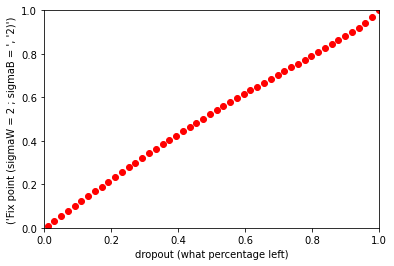

In [13]:
plot_fix_point_diff_dropout(2, 2, resolution = 50)

In [15]:
plot_deriv_corr(0.9, heightline = False, view_angle = (90, -90), resolution = 15, sigma_W_start = 0.001, sigma_W_end = 4, sigma_b_start = 0.001, sigma_b_end = 4)

0.001 0.001
0.001 0.001
0.28664285714285714 0.001
0.5722857142857143 0.001
0.8579285714285715 0.001
1.1435714285714285 0.001
1.4292142857142855 0.001
1.7148571428571429 0.001
2.0005 0.001


KeyboardInterrupt: 